In [2]:
import networkx as nx 
import matplotlib.pyplot as plt 
import numpy as np 
from scipy.stats import linregress
import math
import json

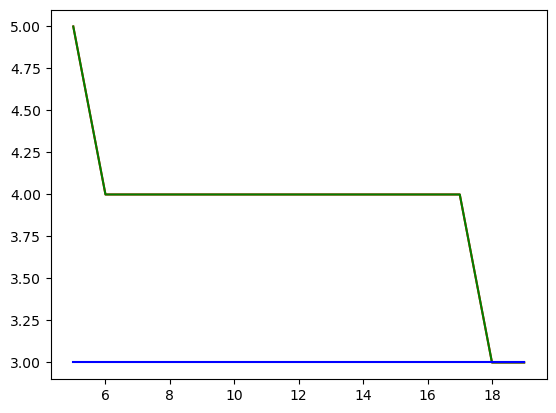

In [3]:
def calculate_density1(k, n):
    return math.ceil(k / (3 - 6/n))

def calculate_density2(k, n):
    return math.floor((k + 3 - 7/n) / (3 - 6/n))

def calculate_density(k):
    return math.ceil((k+1) / 3)

n = list(range(5, 20))
k = 8

y1 = [calculate_density1(k, i) for i in n]
y2 = [calculate_density2(k, i) for i in n]
y3 = [calculate_density(k) for i in n]

plt.plot(n, y1, label='Density 1', color='red')
plt.plot(n, y2, label='Density 2', color='green')
plt.plot(n, y3, label='Density', color='blue')

plt.show()

In [4]:
def _random_subset(seq, m, rng):
    """Return m unique elements from seq.

    This differs from random.sample which can return repeated
    elements if seq holds repeated elements.

    Note: rng is a random.Random or numpy.random.RandomState instance.
    """
    targets = set()
    while len(targets) < m:
        x = rng.choice(seq)
        targets.add(x)
    return targets

In [29]:
def barabasi_albert_graph(n, m, embedding_layers_number, seed=None, initial_graph=None):
    """Returns a random graph using Barabási-Albert preferential attachment

    A graph of $n$ nodes is grown by attaching new nodes each with $m$
    edges that are preferentially attached to existing nodes with high degree.

    Parameters
    ----------
    n : int
        Number of nodes
    m : int
        Number of edges to attach from a new node to existing nodes
    seed : integer, random_state, or None (default)
        Indicator of random number generation state.
        See :ref:`Randomness<randomness>`.
    initial_graph : Graph or None (default)
        Initial network for Barabási-Albert algorithm.
        It should be a connected graph for most use cases.
        A copy of `initial_graph` is used.
        If None, starts from a star graph on (m+1) nodes.

    Returns
    -------
    G : Graph

    Raises
    ------
    NetworkXError
        If `m` does not satisfy ``1 <= m < n``, or
        the initial graph number of nodes m0 does not satisfy ``m <= m0 <= n``.

    References
    ----------
    .. [1] A. L. Barabási and R. Albert "Emergence of scaling in
       random networks", Science 286, pp 509-512, 1999.
    """

    if m < 1 or m >= n:
        raise nx.NetworkXError(
            f"Barabási-Albert network must have m >= 1 and m < n, m = {m}, n = {n}"
        )

    if initial_graph is None:
        # Default initial graph : star graph on (m + 1) nodes
        G = nx.star_graph(m)
    else:
        if len(initial_graph) < m or len(initial_graph) > n:
            raise nx.NetworkXError(
                f"Barabási-Albert initial graph needs between m={m} and n={n} nodes"
            )
        G = initial_graph.copy()

    for index, edge in enumerate(G.edges()):
        G.edges[edge]['color'] = 'blue' if index % embedding_layers_number == 0 else 'red'

    if seed is None:
        seed = np.random.RandomState()

    # List of existing nodes, with nodes repeated once for each adjacent edge
    repeated_nodes = [n for n, d in G.degree() for _ in range(d)]
    # Start adding the other n - m0 nodes.
    source = len(G)
    while source < n:
        # Now choose m unique nodes from the existing nodes
        # Pick uniformly from repeated_nodes (preferential attachment)
        targets = _random_subset(repeated_nodes, m, seed)
        # Add edges to m nodes from the source.
        G.add_edges_from(zip([source] * m, targets))
        # Add one node to the list for each new edge just created.
        repeated_nodes.extend(targets)
        # And the new node "source" has m edges to add to the list.
        repeated_nodes.extend([source] * m)

        # Color the nodes and edges
        # G.nodes[source]['color'] = 'green'
        # for target in targets:
        #     G.edges[source, target]['color'] = 'blue' if source % embedding_layers_number == 0 else 'red'

        source += 1
    return G

In [6]:
def draw_graph(G: nx.Graph):
    """Draw a graph with node and edge colors.

    Parameters
    ----------
    G : nx.Graph
        The graph to draw.
    """

    node_colors = [G.nodes[node]['color'] if 'color' in G.nodes[node] else 'black' for node in G.nodes()]
    edge_colors = [G.edges[edge]['color'] if 'color' in G.edges[edge] else 'black' for edge in G.edges()]
    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_color=node_colors, node_size=50, edge_color=edge_colors, with_labels=False)
    plt.show()

In [7]:
def load_graph_from_file(file_path: str):
    """Draw a graph from a file.

    Parameters
    ----------
    file_path : str
        The path to the file.
    """

    with open(file_path, 'r') as f:
        data = json.load(f)

    G = nx.Graph()

    for node in data['nodes']:
        if 'id' in node and 'color' in node:
            G.add_node(node['id'], color=node['color'])
        elif 'id' in node:
            G.add_node(node['id'])

    for edge in data['edges']:
        if 'source' in edge and 'target' in edge and 'color' in edge:
            G.add_edge(edge['source'], edge['target'], color=edge['color'])
        elif 'source' in edge and 'target' in edge:
            G.add_edge(edge['source'], edge['target'])

    return G

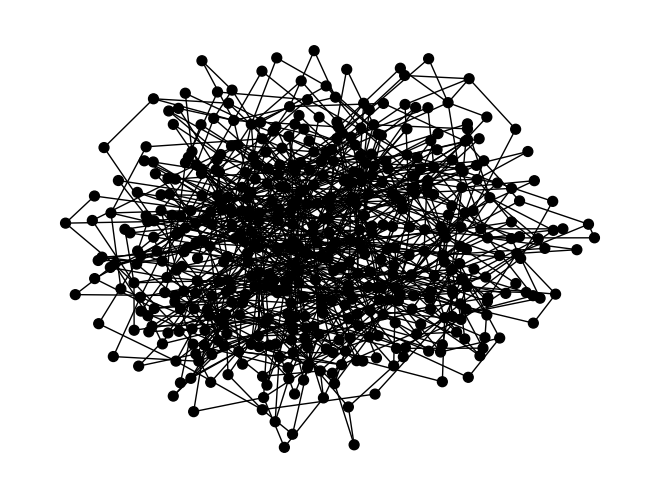

False


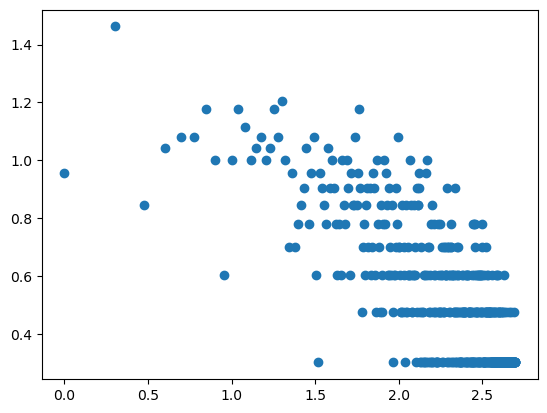

P(k) = k^-0.43


In [51]:
# ba = barabasi_albert_graph(500, 22, 2)
# ba = load_graph_from_file('cmake-build-debug/simple-graph.txt')
ba1 = load_graph_from_file('cmake-build-debug/graph1.txt')
# ba2 = load_graph_from_file('cmake-build-debug/graph2.txt')
# ba3 = load_graph_from_file('cmake-build-debug/graph3.txt')
draw_graph(ba1)
print(nx.is_planar(ba1))
# draw_graph(ba2)
# print(nx.is_planar(ba2))
# draw_graph(ba3)
# print(nx.is_planar(ba3))

degs = [d for n, d in ba1.degree()]
degs_n = [math.log(n, 10) for n,d in ba1.degree() if n != 0 and d != 0]
degs_d = [math.log(d, 10) for n,d in ba1.degree() if n != 0 and d != 0]
plt.scatter(degs_n, degs_d)
plt.show()

slope, intercept, r_value, p_value, std_err = linregress(degs_n, degs_d)
# print(slope, intercept, r_value, p_value, std_err)
print(f"P(k) = k^{round(slope,2)}")

# plt.plot(degs)
# plt.figure()

# plt.hist(degs, bins=range(10))
# print(nx.check_planarity(ba))

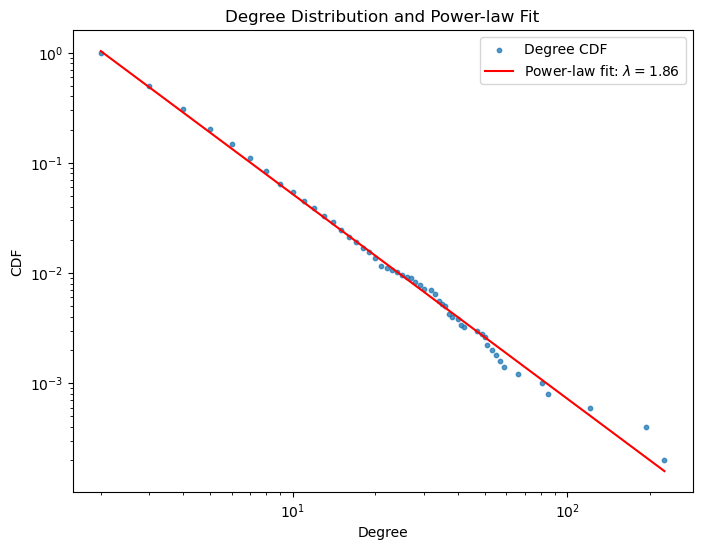

Estimated power-law parameter (lambda): 1.857363984239417


In [54]:
# Step 1: Generate a Barabási-Albert graph
n = 10000  # Number of nodes
m = 3     # Number of edges to attach from a new node to existing nodes
# G = nx.barabasi_albert_graph(n, m)

G = load_graph_from_file('cmake-build-debug/graph1.txt')

# Step 2: Compute the degree of each node
degrees = [G.degree(n) for n in G.nodes()]

# Step 3: Create the degree distribution
degree_counts = np.bincount(degrees)[1:]  # Ignore degree 0

# Step 4: Compute the cumulative distribution function (CDF)
cdf = np.cumsum(degree_counts[::-1])[::-1]
cdf = cdf / cdf[0]  # Normalize

# Filter out zero counts for log-log plot
nonzero_indices = degree_counts > 0
k = np.arange(1, len(degree_counts) + 1)[nonzero_indices]
cdf = cdf[nonzero_indices]

# Step 5: Use log-log transformation and linear regression to estimate λ
log_k = np.log(k)
log_cdf = np.log(cdf)

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(log_k, log_cdf)
lambda_estimate = -slope

# Plot the degree distribution and the fitted power-law line
plt.figure(figsize=(8, 6))
plt.scatter(k, cdf, s=10, alpha=0.75, label='Degree CDF')
plt.plot(k, np.exp(intercept) * k ** slope, 'r-', label=f'Power-law fit: $\\lambda = {lambda_estimate:.2f}$')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree')
plt.ylabel('CDF')
plt.title('Degree Distribution and Power-law Fit')
plt.legend()
plt.show()

print(f"Estimated power-law parameter (lambda): {lambda_estimate}")

In [ ]:
def draw_step_by_step(filename_base: str, min_node_number: int, max_node_number: int):
    graph = load_graph_from_file(f'{filename_base}{max_node_number}.txt')
    node_colors = [graph.nodes[node]['color'] if 'color' in graph.nodes[node] else 'black' for node in graph.nodes()]
    edge_colors = [graph.edges[edge]['color'] if 'color' in graph.edges[edge] else 'black' for edge in graph.edges()]
    poses = nx.spring_layout(graph)

    for i in range(min_node_number, max_node_number + 1):
        graph = load_graph_from_file(f'{filename_base}{i}.txt')
        nx.draw(graph, poses, node_color=node_colors[:i], node_size=100, edge_color=edge_colors[:i])
        nx.draw_networkx_labels(graph, poses, labels={node: node for node in graph.nodes()}, font_size=12, font_color='white')
        plt.show()

        with open(filename_base + f'metric-{i}.txt') as metric:
            for line in metric.readlines():
                print(line.strip())

        is_planar, counterexample = nx.check_planarity(graph, True)
        if is_planar:
            print(f'Graph {i} is planar')
        else:
            print(f'Graph {i} is not planar. Counterexample:')
            print(counterexample.nodes())
            print(counterexample.edges())
            nx.draw(counterexample, poses, node_color='grey', node_size=100, edge_color='grey')
            nx.draw_networkx_labels(counterexample, poses, labels={node: node for node in counterexample.nodes()}, font_size=12, font_color='white')
    

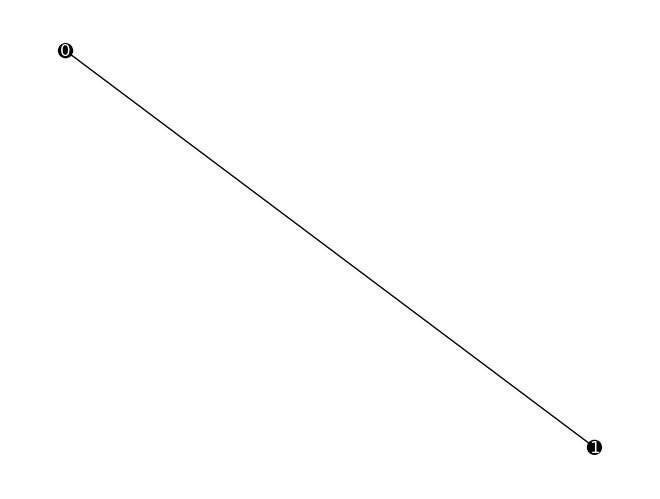

Node: 0 K_5: 0
Node: 1 K_5: 0
Graph 2 is planar


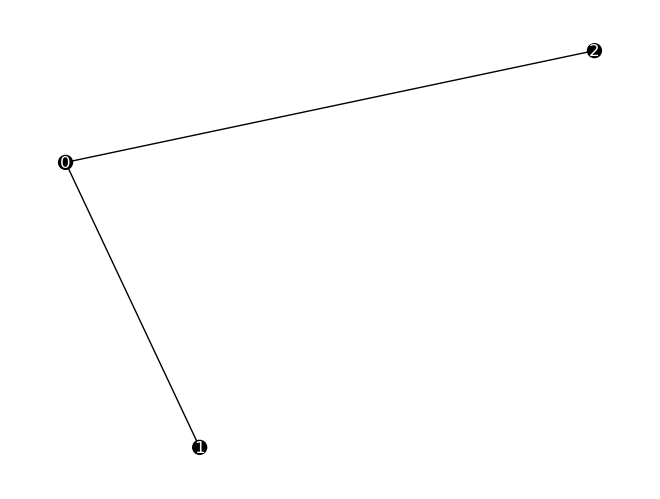

Node: 0 K_5: 1
Node: 1 K_5: 1
Node: 2 K_5: 1
Graph 3 is planar


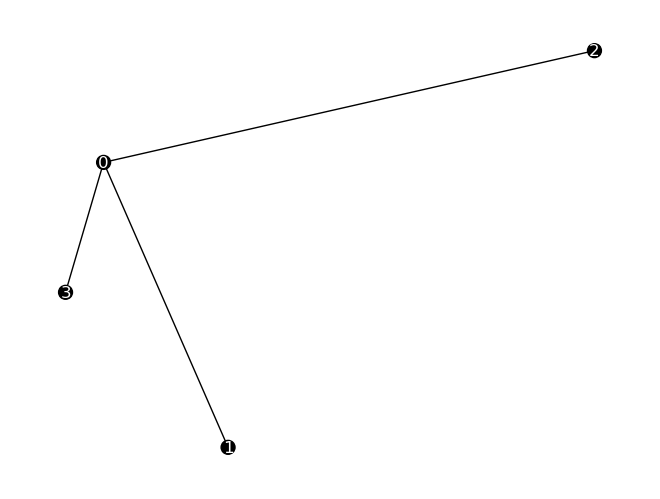

Node: 0 K_5: 2
Node: 1 K_5: 2
Node: 2 K_5: 2
Node: 3 K_5: 2
Graph 4 is planar


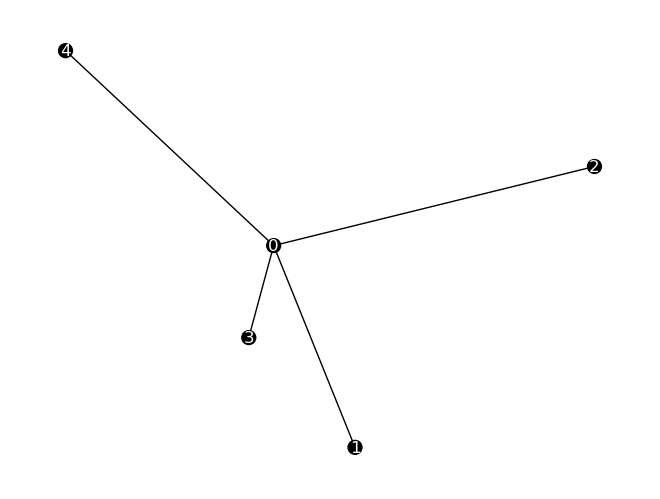

Node: 0 K_5: 3
Node: 1 K_5: 3
Node: 2 K_5: 3
Node: 3 K_5: 3
Node: 4 K_5: 3
Graph 5 is planar


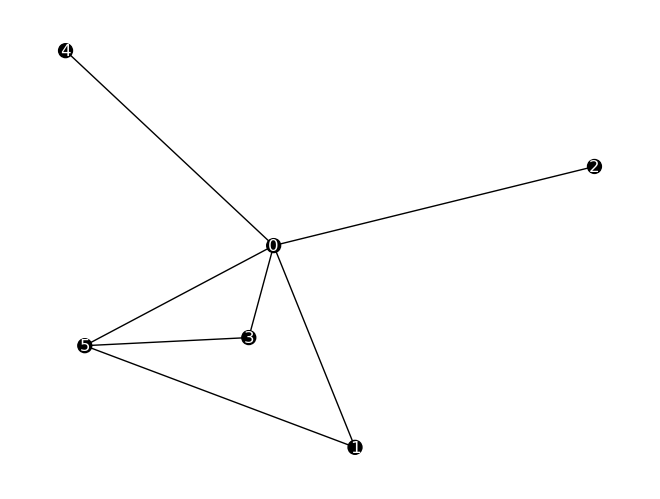

Node: 0 K_5: 15
Node: 1 K_5: 21.75
Node: 2 K_5: 14
Node: 3 K_5: 21.75
Node: 4 K_5: 14
Node: 5 K_5: 18.5
Graph 6 is planar


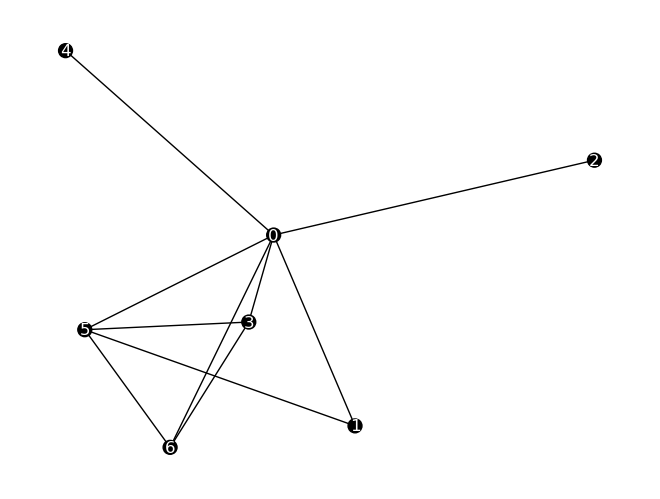

Node: 0 K_5: 40.3333
Node: 1 K_5: 45.2667
Node: 2 K_5: 28
Node: 3 K_5: 54.1333
Node: 4 K_5: 28
Node: 5 K_5: 46.6
Node: 6 K_5: 54.1333
Graph 7 is planar


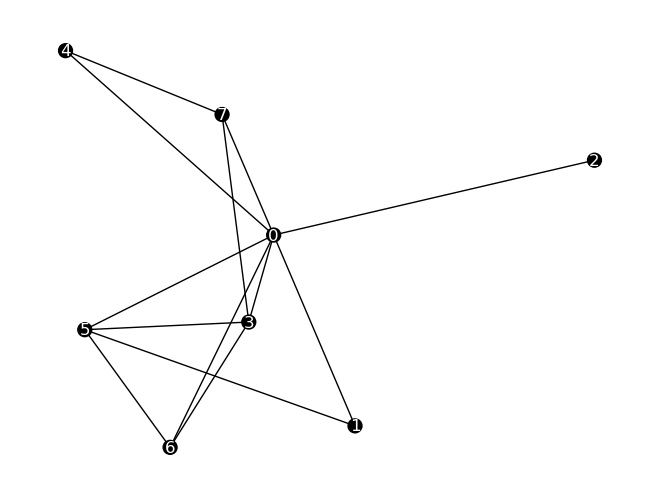

Node: 0 K_5: 64.2778
Node: 1 K_5: 68.7222
Node: 2 K_5: 43.1667
Node: 3 K_5: 88.4584
Node: 4 K_5: 61.3148
Node: 5 K_5: 81.0556
Node: 6 K_5: 89.9445
Node: 7 K_5: 73.9815
Graph 8 is planar


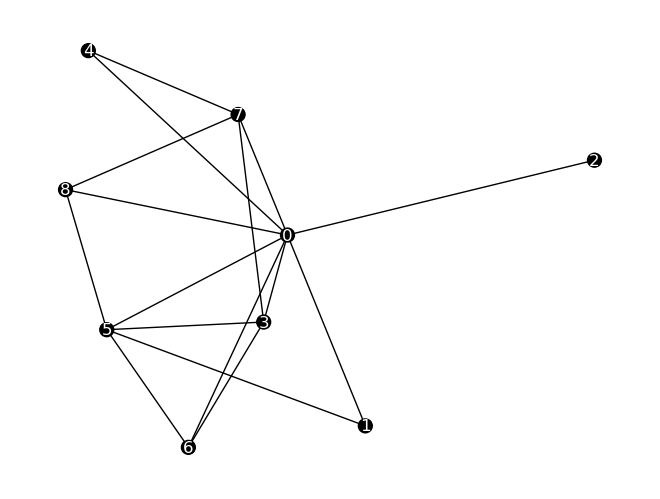

Node: 0 K_5: 103.264
Node: 1 K_5: 103.816
Node: 2 K_5: 62.0278
Node: 3 K_5: 142.274
Node: 4 K_5: 96.0585
Node: 5 K_5: 121.508
Node: 6 K_5: 132.728
Node: 7 K_5: 116.179
Node: 8 K_5: 132.312
Graph 9 is planar


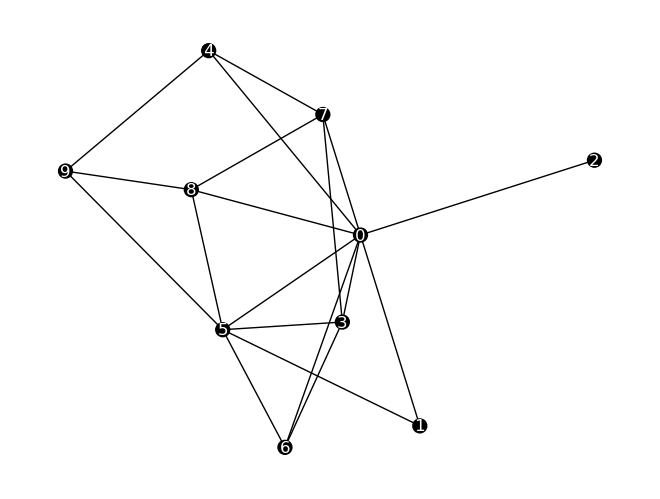

Node: 0 K_5: 157.246
Node: 1 K_5: 133.748
Node: 2 K_5: 78.5796
Node: 3 K_5: 180.806
Node: 4 K_5: 138.214
Node: 5 K_5: 162.775
Node: 6 K_5: 168.222
Node: 7 K_5: 165.301
Node: 8 K_5: 180.564
Node: 9 K_5: 135.295
Graph 10 is not planar. Counterexample:
[0, 4, 6, 8, 3, 7, 9, 5]
[(0, 4), (0, 6), (0, 8), (4, 7), (4, 9), (6, 3), (6, 5), (8, 7), (8, 9), (3, 7), (9, 5)]


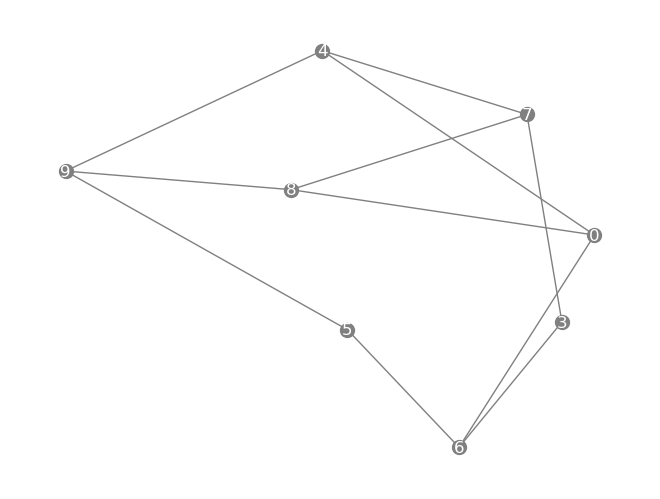

In [ ]:
draw_step_by_step('cmake-build-debug/graph1-', 2, 10)

In [ ]:
# # Function to count the number of paths of length k from a specific source node
# def count_paths_length_k_from_node(adj_matrix, k, source):
#     # Compute A^k
#     paths_length_k = np.linalg.matrix_power(adj_matrix, k)
#     # Extract paths starting from the source node
#     return paths_length_k[source]

# # Function to calculate the total number of paths from the last added node in a BA graph
# def total_paths_from_last_node(n, m):
#     # Generate a Barabási-Albert graph
#     G = nx.barabasi_albert_graph(n, m)
    
#     # Adjacency matrix of the graph
#     A = nx.adjacency_matrix(G).todense()
    
#     # The last added node in a BA graph is the node with the highest index
#     last_node = n - 1
    
#     # Calculate the diameter of the graph
#     diameter = nx.diameter(G)
    
#     # Initialize variable to store total paths from the last node
#     total_paths = 0
    
#     # Calculate paths for each length from 1 to diameter starting from the last node
#     for k in range(1, diameter + 1):
#         paths_from_last_node = count_paths_length_k_from_node(A, k, last_node)
#         total_paths += np.sum(paths_from_last_node)
    
#     return total_paths

# # Calculate the average number of paths
# N = list(range(10, 500, 50))
# M = 2
# K = 100
# AVG_PATHS = []
# for n in N:
#     print(n)
#     AVG_PATHS.append(sum([total_paths_from_last_node(n, M) for _ in range(K)]) / K)

# plt.plot(N, AVG_PATHS)
# plt.plot(N, [0.4 * n**2 * math.sqrt(n)  for n in N])
# plt.show()